# Optimizing Graph-Based Growth Dynamics with Differentiable PDE Models

## Description

This notebook demonstrates how to model **temporal growth processes on graphs** using a custom **differentiable PDE-inspired framework** implemented in TensorFlow/Keras.

The workflow includes:

- **Graph-based data preparation**:  
  Load a temporal growth graph (with spatial positions `pos` and appearance times `t`) and extract windowed apical features.

- **Trajectory construction**:  
  Convert features into time–distance sequences and interpolate them onto a uniform grid for consistency.

- **Model definition**:  
  Implement a trainable PDE-inspired simulation model (`Model1D`) and a Keras-compatible training wrapper (`ModelTrainer`).

- **Training procedure**:  
  Optimize global and local parameters with tailored optimizers, gradient accumulation, and learning rate scheduling.

- **Evaluation**:  
  Compare predicted vs. true displacement and velocity trajectories to assess the model’s ability to capture growth dynamics.

This approach illustrates how **dynamical processes on graphs** can be transformed into optimization-ready arrays and fitted efficiently with gradient-based methods.

### Environment Setup and Core Library Imports

- **Future annotations:**  
  `from __future__ import annotations` enables postponed evaluation of type hints (cleaner class definitions).
  
- **System and path management:**  
  `os`, `sys`, and `sys.path.append("../")` ensure access to local modules (e.g., GradGraph).

- **Data handling and computation:**  
  - `orjson`: fast JSON serialization/deserialization for graph data.  
  - `numpy`: numerical arrays and vectorized operations.  
  - `scipy.interpolate.CubicSpline`: smooth interpolation of trajectory data.  

- **Graph processing:**  
  `networkx`: construction and manipulation of graph-structured data.  

- **Machine learning:**  
  `tensorflow`: defines differentiable PDE-inspired layers and manages training.  

- **Visualization:**  
  `matplotlib.pyplot` with `%matplotlib inline` for interactive plotting in notebooks.  

In [1]:
from __future__ import annotations

import os
import sys
import orjson
import networkx
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

sys.path.append("../")
%matplotlib inline

### Install GradGraph

You can install **GradGraph** in two ways, using the current Python executable (`sys.executable`):

- **Standard mode (package index):**

  ```python
  !{sys.executable} -m pip install gradgraph  
  ```
  - Installs the latest published version from PyPI (or configured index).  
  - Recommended for regular usage when you don’t need to modify the source.  

- **Editable mode (development):**

  ```python
  !{sys.executable} -m pip install -e ../  
  ```
  - Installs GradGraph from the parent directory in *editable mode*.  
  - Local source code changes take effect immediately without reinstalling.  
  - Recommended during development and debugging of custom layers, trainers, or utilities.  

In [2]:
# !{sys.executable} -m pip install gradgraph
# !{sys.executable} -m pip install -e ../

### Import GradGraph Utilities and Training Components

- **Feature extraction:**  
  `gradgraph.graph.features` provides methods to compute temporal and structural features from graphs (e.g., apical distances).

- **TensorFlow initialization:**  
  `initialize_tensorflow` sets deterministic seeds and configures the TF runtime environment for reproducible training.

- **Base PDE system layer:**  
  `BasePDESystemLayer` is the abstract base class for defining custom differentiable PDE-inspired layers (e.g., `Model1D`).

- **Trainer base class:**  
  `BasePDESystemTrainer` extends `tf.keras.Model` to manage training loops, optimizers, and data flow for PDE systems.

- **Constraints:**  
  `InBetween` enforces numerical constraints (e.g., positivity, bounded parameters) during optimization.

- **Callbacks:**  
  - `EarlyStoppingByThreshold`: halts training once loss falls below a predefined threshold.  
  - `ReduceLROnPlateau`: adaptively decreases the learning rate when progress stalls.  

In [3]:
from gradgraph.graph import features
from gradgraph.optimization.tf.utils import initialize_tensorflow
from gradgraph.optimization.tf.layers import BasePDESystemLayer
from gradgraph.optimization.tf.trainer import BasePDESystemTrainer
from gradgraph.optimization.tf.constraints import InBetween
from gradgraph.optimization.tf.callbacks import (
    EarlyStoppingByThreshold,
    ReduceLROnPlateau,
)

### TensorFlow Initialization and Precision Settings

This block configures TensorFlow’s numerical precision, debugging options, and device setup:

- **Default float type:**  
  - Sets `floatx = "float32"` and updates TensorFlow’s global dtype with  
    `tf.keras.backend.set_floatx(floatx)`.  
  - Ensures that all layers, optimizers, and variables consistently use single precision (32-bit floats).  

- **Mixed precision policy:**  
  - Creates and applies a global policy with `tf.keras.mixed_precision.Policy(floatx)`.  
  - Even though mixed precision can enable `float16`/`bfloat16` on GPUs/TPUs, here it is fixed to `float32` for stability.  

- **Numerical checks:**  
  - `tf.debugging.enable_check_numerics()` inserts runtime checks for `NaN` and `Inf` values in TensorFlow ops.  
  - Recommended during development to catch exploding gradients or instability early.  
  - On some devices/backends this may trigger compatibility errors; in that case, this line should be **commented out**.  

- **Eager execution (optional):**  
  - `tf.config.run_functions_eagerly(True)` forces TensorFlow to run functions in eager mode instead of graph mode.  
  - Normally **left commented** for performance.  
  - If the TensorFlow binary was built **without graph optimizations** (common on some non-standard hardware builds), uncomment this line to avoid unexpected errors.  

- **Device initialization:**  
  - `initialize_tensorflow(use_gpu=False)` sets up TensorFlow to run explicitly on CPU, disabling GPU usage.  

In [4]:
floatx = 'float32'
dtype = tf.as_dtype(floatx)
tf.keras.backend.set_floatx(floatx)
policy = tf.keras.mixed_precision.Policy(floatx)
tf.keras.mixed_precision.set_global_policy(policy)
tf.debugging.enable_check_numerics()
# tf.config.run_functions_eagerly(True)

initialize_tensorflow(use_gpu=False)

INFO:tensorflow:Enabled check-numerics callback in thread MainThread
1 Physical CPUs, 1 Logical CPUs


### Plot Training History

The `plot_history` function provides a quick way to visualize training metrics stored in a history dictionary.

- **Input:**  
  - `history (dict)`: A dictionary where keys are metric names (e.g., `"loss"`, `"accuracy"`) and values are lists of values per epoch.  

- **Behavior:**  
  - Creates a grid of subplots sized automatically based on the number of metrics.  
  - Each metric is plotted across epochs with labels, grid lines, and legends.  
  - Unused subplot spaces are left empty but still gridded for layout consistency.  
  - A shared x-axis (epochs) is used, while y-axes differ per metric.  

- **Output:**  
  - Returns a tuple `(fig, axes)` containing the Matplotlib `Figure` and array of `Axes`.  
  - Useful for further customization or saving plots.  

- **Example usage:**  
  history = {"loss": [0.9, 0.7, 0.5], "accuracy": [0.6, 0.75, 0.85]}  
  fig, axes = plot_history(history)  

In [5]:
def plot_history(history: dict) -> tuple[plt.Figure, plt.Axes]:
    n = len(history)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n/nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10), sharex=True, sharey=False)
    axes = np.array(axes).reshape(-1)

    for i, (k, v) in enumerate(history.items()):
        ax = axes[i]
        ax.plot(v, label=k.title())
        ax.set_ylabel(k.title())
        ax.set_xlabel("Epoch")
        ax.grid(True)
        ax.legend()
        ax.set_yscale("log")

    for i in range(n, len(axes)):
        axes[i].grid(True)
    
    fig.tight_layout()
    return fig, axes

### Plot Sequence Predictions

The `plot_sequence_predictions` function visualizes true vs. predicted sequences across multiple samples.

- **Input:**  
  - `y_true (ndarray)`: Ground-truth sequences of shape `(n_samples, seq_len)`.  
  - `y_pred (ndarray)`: Predicted sequences of the same shape.  

- **Behavior:**  
  - Creates a grid of subplots sized automatically based on the number of samples.  
  - Each subplot compares one sample’s true sequence (`True`) with its predicted sequence (`Pred`).  
  - The x-axis represents time steps (from `0` to `seq_len - 1`).  
  - Gridlines are shown for readability, and unused subplot spaces remain empty.  
  - A shared legend (`True` vs. `Pred`) is placed in the top-right corner of the figure.  

- **Output:**  
  - Returns a tuple `(fig, axes)` containing the Matplotlib `Figure` and array of `Axes`.  
  - Enables further customization or saving of the generated plots.  

- **Example usage:**  
  fig, axes = plot_sequence_predictions(y_true, y_pred)  

In [6]:
def plot_sequence_predictions(y_true, y_pred) -> tuple[plt.Figure, plt.Axes]:
    n_samples = y_true.shape[0]
    nrows = int(np.ceil(np.sqrt(n_samples)))
    ncols = int(np.ceil(n_samples/nrows))
    t = np.arange(y_true.shape[1])

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for i, ax in enumerate(axes):
        ax.grid(True)
        if len(y_true) <= i:
            continue
        ax.plot(t, y_true[i], label="True")
        ax.plot(t, y_pred[i], "--", label="Pred")
        ax.set_title(f"Sample {i}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    return fig, axes

### Trainable Keras Model for PDE Simulation

- Inherits from `BasePDESystemTrainer` (a subclass of `tf.keras.Model`)
- Encapsulates the `Model1D` layer to provide an end-to-end trainable model
- Implements:
  - `build`: constructs the underlying PDE system
  - `call`: forwards inputs through the PDE simulation
  - `compute_output_shape` and `get_config`: ensure compatibility with Keras APIs
- Provides the standard Keras model interface (fit, evaluate, predict) for training PDE-driven dynamics

In [7]:
class ModelTrainer(BasePDESystemTrainer):
    def __init__(self, n_seq, nt, nx, dx, dt, **kwargs):
        super().__init__(**kwargs)
        self.n_seq = n_seq
        self.nt = nt
        self.nx = nx
        self.dt = dt
        self.dx = dx

    def build(self, input_shape):
        if self.built:
            return
        self.pde = Model1D(self.n_seq, self.nt, self.nx, self.dx, self.dt)
        self.pde.build(input_shape)
        super().build(input_shape)

    def call(self, inputs, training=False):
        return self.pde.call(inputs, training=training)

    def compute_output_shape(self, input_shape):
        return self.pde.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(self.pde.get_config())
        return config

### Differentiable 1D Simulation Model

We want to solve the ordinary differential equation (ODE):

$ \frac{dL}{dt} = \alpha \, t + X_i $

where:  
- $\alpha$ is a **global trainable parameter**, shared across all samples.  
- $X_i$ is a **local trainable parameter** specific to sample $i$.  

---

#### Analytical Solution

Integrating directly gives:

$ L_i(t) = \tfrac{1}{2} \alpha \, t^2 + X_i \, t + C_i, $

where $C_i$ is an integration constant or the initial condition for sample $i$.

---

#### Discrete Approximation (Euler Method)

We discretize time at points $t_0, t_1, \dots, t_k$ with uniform step size $\Delta t = t_{k+1} - t_k$.

- **Explicit Euler**:

$ L_{i,\,k+1} = L_{i,\,k} + \big( \alpha \, t_k + X_i \big)\,\Delta t $

- **Implicit Euler**:

$ L_{i,\,k+1} = L_{i,\,k} + \big( \alpha \, t_{k+1} + X_i \big)\,\Delta t $

Since the derivative does not depend on $L$, both explicit and implicit forms are straightforward updates.

---

#### Improved Scheme (Trapezoidal / Heun)

A second-order accurate scheme averages the slope at the start and end of the interval:

$ L_{i,\,k+1} = L_{i,\,k} + \tfrac{1}{2}\Big[ (\alpha \, t_k + X_i) + (\alpha \, t_{k+1} + X_i) \Big] \,\Delta t $

---

#### Notes

- **Global parameter ($\alpha$)**: controls the curvature of the trajectories and is learned jointly across all samples.  
- **Local parameter ($X_i$)**: accounts for sample-specific slope offsets.  
- Built as a custom `tf.keras.layers.Layer` with support for gradient-based training
- **Modeling note:** Care must be taken to ensure that parameters are not redundantly coupled.  
  If two parameters encode overlapping effects, one should be absorbed into the other;  
  otherwise, training may fail to converge or yield unstable solutions.

---

#### Note on Well-Posedness of the Model

For the training process to converge reliably, the model must be **well-posed**:

- The initial condition $L_{i,0}$ (or $C_i$ in the analytical form) should be specified or made trainable, so that the trajectory is uniquely determined.  
- The global parameter $\alpha$ and local parameters $X_i$ must play **distinct roles** (curvature vs. slope offset). This avoids redundancy, ensuring that $\alpha$ does not collapse to zero while $X_i$ absorbs all variations.  
- Time discretization $\Delta t$ should be chosen (or normalized) so that both $\alpha$ and $X_i$ contribute on a comparable scale, preventing one parameter from dominating the gradients.  

With these conditions, the ODE is well-posed and the optimization problem becomes identifiable, allowing both the global and local parameters to converge to meaningful values.

In [8]:
class Model1D(BasePDESystemLayer):
    def __init__(self, n_seq, nt, nx, dx, dt, **kwargs):
        super().__init__(**kwargs)
        self.n_seq = n_seq
        self.nt = nt
        self.nx = nx
        self.dt = dt
        self.dx = dx

    def build(self, input_shape):
        if self.built:
            return
        self.alpha = self.add_global_weight(
            name="alpha",
            shape=(),
            initializer=tf.constant_initializer(2e1),
            constraint=InBetween(0),
            dtype=self.dtype,
            trainable=True,
        )
        self.X = self.add_local_embedding(
            name="X",
            input_dim=self.n_seq,
            output_dim=1,
            embeddings_initializer=tf.constant_initializer(1e0),
            embeddings_constraint=InBetween(0),
            dtype=self.dtype,
            trainable=True,
        )
        ids = input_shape[0]
        self.X.build(ids)
        super().build(input_shape)

    def cond(self, n, *args):
        return n < self.nt-1

    def body(self, n, L, V, X):
        L0 = L.read(n)
        
        t = tf.cast(n, self.dtype) * self.dt
        V0 = self.alpha * t + X
        V1 = self.alpha * (t+self.dt) + X
        L1 = L0 + 0.5 * (V0 + V1) * self.dt

        n = n+1
        L = L.write(n, L1)
        V = V.write(n-1, V0)
        V = V.write(n, V1)

        return n, L, V, X

    def call(self, inputs, training=False):
        ids, L0 = inputs['ids'], inputs['L_init']
        X = self.X(ids, training=training)
        X = tf.squeeze(X, axis=-1)

        L = tf.TensorArray(
            dtype=self.dtype,
            size=self.nt,
            dynamic_size=False,
            clear_after_read=False
        )
        L = L.write(0, L0)

        V = tf.TensorArray(
            dtype=self.dtype,
            size=self.nt,
            dynamic_size=False,
            clear_after_read=False
        )

        _, L, V, X = tf.while_loop(
            self.cond,
            self.body,
            loop_vars=(0, L, V, X),
            parallel_iterations=1
        )

        V = V.stack()
        V = tf.transpose(V, perm=[1, 0])

        L = L.stack()
        L = tf.transpose(L, perm=[1, 0])

        return L, V

    def compute_output_shape(self, input_shape):
        return [
            (None, self.nt),
            (None, self.nt),
        ]

    def get_config(self):
        cfg = super().get_config()
        cfg.update(dict(
            n_seq=self.n_seq,
            nt=self.nt,
            nx=self.nx,
            dt=self.dt,
            dx=self.dx,
        ))
        return cfg

### Hyperparameter Definitions

- `span`: temporal or spatial span of the simulation
- `epochs`: number of training epochs
- `batch_size`: training batch size
- `nt`: number of time steps
- `nx`: number of spatial discretization points

In [9]:
span = 5

epochs = int(1e4)
batch_size = 256

nt = 100
nx = 64

### Load Graph Data from JSON

- `graph_filename`: path to the JSON file containing the graph
- `min_per_frame`: temporal resolution parameter (minutes per frame)
- Loads the graph with `orjson` and reconstructs it using `networkx.node_link_graph`
- Each node has:
  - `pos`: spatial position (x, y)
  - `t`: time of appearance
- The graph encodes **temporal dynamics** of growth with a **subcubic branching structure**
- Constructed with **three branches** emanating from a single root node, each branch growing according to  
  $$
  v(t) = \alpha \, t, \quad \alpha = 3.0
  $$

In [10]:
graph_filename = './example_linear_growth_graph.json'
min_per_frame = 1.0
with open(os.path.abspath(graph_filename), 'r') as f:
    json_str = orjson.loads(f.read())
G = networkx.node_link_graph(json_str, link='edges')
pos = networkx.get_node_attributes(G, 'pos')
times = networkx.get_node_attributes(G, 't')
print(G)

DiGraph with 34 nodes and 33 edges


### Visualize Temporal Graph Structure

- Draws the graph `G` using the spatial positions stored in `pos`
- Colors nodes according to their `t` attribute (time of appearance)
- Displays node labels for easier inspection of node indices
- Provides a quick view of the **temporal progression of growth** across the graph

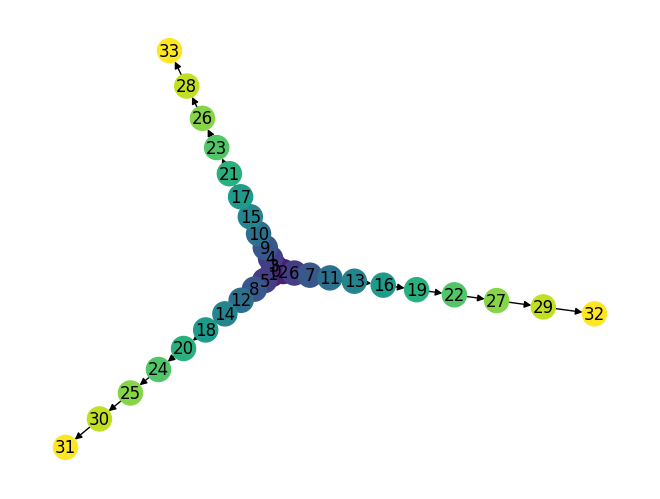

In [11]:
networkx.draw(
    G, 
    pos=pos, 
    with_labels=True, 
    nodelist=list(times.keys()),
    node_color=list(times.values())
)
plt.savefig("graph.png")
plt.show()

### Extract Windowed Temporal Apical Features

- Uses `features.windowed_temporal_apical_features` to compute time-dependent features from the graph `G`
- Inputs:
  - `pos`: spatial positions of nodes
  - `span`: temporal span for the window
  - `dt`: resolution (minutes per frame)
- Converts the resulting generator into a dictionary for easier access
- Captures **apical growth dynamics** in a windowed temporal representation

In [12]:
windowed_features = features.windowed_temporal_apical_features(
    G,
    pos=pos,
    span=span,
    dt=min_per_frame
)
windowed_features = dict(windowed_features)

### Prepare Distance Data from Windowed Features

- Converts `windowed_features` (time–distance pairs) into a NumPy array
- `distances = np.squeeze(data[:, 1::2])`: extracts distance values (dropping time columns)
- `L0s = distances[:, 0]`: initial distances at the first time step
- `n_seq = distances.shape[0]`: number of sequences (one per apical feature)
- Prints the number of available growth sequences

In [13]:
data = np.array(list(windowed_features.values()))
distances = np.squeeze(data[:, 1::2])
L0s = distances[:, 0]
n_seq = distances.shape[0]
print(n_seq)

84


### Smooth Interpolation of Distance Sequences with Cubic Splines

- `x_target`: target grid of `nt` uniformly spaced points in [0, 1]
- `x_ref`: reference grid of `span` points (original resolution of the data)
- Builds a `CubicSpline` for each distance sequence `d` over `x_ref`
- Evaluates each spline on `x_target` to produce `L_true`
- `L_true` contains smoothly interpolated distance trajectories aligned on a common grid
- Note: cubic splines may overshoot or break monotonicity; consider `PchipInterpolator` if monotonic growth must be preserved

In [14]:
x_target = np.linspace(0.0, 1.0, nt)
x_ref = np.linspace(0.0, 1.0, span)

splines = (CubicSpline(x_ref, d, extrapolate=True) for d in distances)
L_true = np.array([spline(x_target) for spline in splines])

### Compute Spatial and Temporal Discretization

- Spatial step size:
  $\Delta x = \frac{\min(L_0)}{n_x}$

- Temporal step size:
  $\Delta t = \frac{(\text{span} - 1) \cdot \Delta t_{\text{frame}}}{n_t - 1}$

In [15]:
dx = float(np.min(L0s)/nx)
dt = (span-1)*min_per_frame/(nt-1)
print(f"{dx=}, {dt=}")

dx=0.0703125, dt=0.04040404040404041


### Compute Velocity and Acceleration from Interpolated Distances

- Uses finite differences (`np.gradient`) along the temporal axis to estimate derivatives
- Velocity:
  $v(t) \;=\; \frac{\partial L(t)}{\partial t}$
- Acceleration:
  $a(t) \;=\; \frac{\partial^2 L(t)}{\partial t^2}$
- `axis=1` ensures gradients are taken over the time dimension

In [16]:
velocity = np.gradient(L_true, dt, axis=1)
acceleration = np.gradient(velocity, dt, axis=1)

### Build Training Dataset with `tf.data`

This code constructs a TensorFlow `Dataset` for training sequence models.

- **Preparation:**  
  - `L_true`: Ground-truth labels cast to the target dtype.
    $$L_{\text{true}} \in \mathbb{R}^{n_{\text{seq}} \times n_t}$$
  - `L_init`: Initial values (`L0s`) cast to the target dtype.
    $$L_{0} \in \mathbb{R}^{n_{\text{seq}}}$$
  - `ids`: Sequence indices ranging from `0` to `n_seq - 1`.
    $$\text{ids} = [0, 1, \dots, n_{\text{seq}}-1]$$

- **Dataset construction:**  
  - Convert each array (`ids`, `L_init`, `L_true`) into a `tf.data.Dataset`.  
  - Use `tf.data.Dataset.zip` to combine them into tuples of:  
    - **Inputs**: a dictionary with keys  
      - `'ids'`: sequence index  
      - `'L_init'`: initial values  
    - **Targets**: `L_true` (ground-truth labels).  

- **Batching and prefetching:**  
  - Apply `.batch(batch_size)` to group samples.  
  - Use `.prefetch(tf.data.AUTOTUNE)` for efficient input pipeline parallelism.  

- **Result:**  
  - `train_ds` is an optimized, batched dataset suitable for model training.  

In [17]:
L_true = tf.cast(L_true, dtype)
L_init = tf.cast(L0s, dtype)
ids = tf.range(n_seq)

ids = tf.data.Dataset.from_tensor_slices(ids)
L_init = tf.data.Dataset.from_tensor_slices(L_init)
L_true = tf.data.Dataset.from_tensor_slices(L_true)

train_ds = tf.data.Dataset.zip(({'ids': ids, 'L_init': L_init}, L_true))
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Define Keras Model Inputs and Instantiate Trainer

- Defines model inputs:
  - `ids`: integer sequence identifiers  
    $\text{ids} \in \{0, 1, \dots, n_{\text{seq}}-1\}$
  - `L_init`: initial distance values  
    $L_{\text{init}} \in \mathbb{R}^{n_{\text{seq}}}$
    
- Instantiates the custom trainer model:
  $\text{ModelTrainer}(n_{\text{seq}}, n_t, n_x, \Delta x, \Delta t)$

- Calls the model once with the defined inputs to build the computational graph

In [18]:
inputs = (
    tf.keras.Input(shape=(), name="ids", dtype=tf.int32),
    tf.keras.Input(shape=(), name="L_init", dtype=dtype),
)
model_name = 'linear_model'
model = ModelTrainer(n_seq, nt, nx, dx, dt, dtype=dtype, name=model_name)
model(inputs)
print(model.name)

linear_model


### Compile the Trainer Model with Optimizers and Loss

- **Gradient accumulation:**  
  The effective batch size is controlled by accumulating gradients across multiple steps (all batches in one epoch).  
  $$
  \text{gradient\_accumulation\_steps} = \left\lfloor \frac{n_{\text{seq}}}{\text{batch\_size}} \right\rfloor
  $$
  This allows training on large datasets without exceeding memory limits.

- **Global optimizer:**  
  Parameters that are *shared across all sequences* (e.g., the global coefficient $\alpha$) are updated with an Adam optimizer using a relatively small learning rate for stability.  
  Gradient clipping ($\|g\| \leq 1.0$) prevents exploding gradients, while the accumulation factor ensures that global parameters are updated less frequently but with more averaged gradient information.

- **Local optimizer:**  
  Sequence-specific parameters (e.g., per-sequence embeddings $X$) are updated with a larger learning rate to allow rapid adaptation to individual growth trajectories.  
  Gradient clipping is again applied to stabilize updates.

- **Losses and metrics (multi-output):**  
  The model is compiled with two outputs; only the **first** output contributes to the loss/metrics:  
  - Loss: Mean Squared Error on output 1; none on output 2 → `loss = [MSE, None]`  
  - Metrics: MAE on output 1; none on output 2 → `metrics = [["mae"], None]`  
  Interpretation: MSE penalizes larger deviations quadratically, while MAE offers a more interpretable, scale-aligned metric.
  Training minimizes the mean squared error (MSE) between predicted and true distance trajectories:  
  $$
  \mathcal{L}(y, \hat{y}) = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2
  $$
  This penalizes deviations quadratically, emphasizing larger errors more strongly.
- **Summary:**  
  `model.summary()` provides a full overview of trainable parameters and architecture before training.

In [19]:
print(f"gradient_accumulation_steps={int(n_seq//batch_size)}")

global_opt = {
    "alpha": tf.keras.optimizers.Adam(
        learning_rate=1e-2,
        clipnorm=1e0,
        gradient_accumulation_steps=max(int(n_seq//batch_size)*2, 2),
    ),
}
local_opt=tf.keras.optimizers.Adam(
    learning_rate=1e-1,
    clipnorm=1e0,
)

loss = tf.keras.losses.MeanSquaredError()

model.compile(
    local_opt,
    global_opt,
    loss=[loss, None],
    metrics=[["mae"], None]
)
model.summary()

gradient_accumulation_steps=0


Model: "linear_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ model1d (Model1D)               │ [(None, 100), (None,   │            85 │
│                                 │ 100)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

### Initialize and Warm-Start Model Parameters

- **Set global coefficient:** assign $\alpha \leftarrow 1.0$ to provide a stable starting slope for $v(t) = \alpha\, t + X$.

In [20]:
model.pde.alpha.assign(1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

### Train the Model with Checkpointing, Early Stopping, and Adaptive Learning Rates

- **Fit call:** trains on inputs $(\text{ids}, L_{\text{init}})$ to match targets $L_{\text{true}}$ for `epochs = epochs` with mini-batches of size `batch_size`.

- **Model checkpointing:** saves the best-performing weights (w.r.t. training loss) to `../examples/{model.name}.keras`, ensuring reproducibility and a safe fallback if later epochs overfit.

- **Early stopping by threshold:** stops training once the monitored loss falls below $10^{-3}$ and restores the best weights, preventing unnecessary iterations once an acceptable fit is reached.

- **Dual learning-rate schedulers (ReduceLROnPlateau):**
  - `optimizer`: reduces its learning rate by a factor of $0.99$ after $10$ epochs without improvement in the loss (floor at $10^{-4}$).
  - `alpha_global_optimizer`: independently schedules the global optimizer for $\alpha$ with the same policy.  
  This decoupling lets sequence-specific parameters and the global coefficient $\alpha$ adapt at different paces.

- **Monitoring metric:** `"loss"` is used consistently across callbacks, aligning checkpointing, early stopping, and LR scheduling with the optimization objective.

- **Output:** `history` contains per-epoch metrics for post-hoc analysis and plotting (e.g., training curves).

In [21]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(
                '../examples',
                f'{model.name}.keras'
            ),
            monitor="loss",
            save_best_only=True,
            mode="min",
            verbose=0
        ),
        EarlyStoppingByThreshold(
            monitor='loss',
            threshold=1e-5,
            restore_best_weights=True,
            mode='min',
            verbose=0
        ),
        ReduceLROnPlateau(
            optimizer='optimizer',
            monitor="loss",
            factor=0.99,
            patience=10,
            verbose=1,
            min_lr=1e-4,
        ),
        ReduceLROnPlateau(
            optimizer='alpha_global_optimizer',
            monitor="loss",
            factor=0.99,
            patience=10,
            verbose=1,
            min_lr=1e-4,
        ),
    ]
)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - alpha: 1.0000 - alpha_global_grad_norm: 229.7543 - local_grad_norm: 17.4840 - loss: 1200.8521 - mae: 27.3603 - learning_rate: 0.0100
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - alpha: 1.0100 - alpha_global_grad_norm: 228.1384 - local_grad_norm: 17.3744 - loss: 1185.8815 - mae: 27.1603 - learning_rate: 0.0100
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - alpha: 1.0100 - alpha_global_grad_norm: 226.2624 - local_grad_norm: 17.2483 - loss: 1168.7542 - mae: 26.9335 - learning_rate: 0.0100
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - alpha: 1.0200 - alpha_global_grad_norm: 224.6465 - local_grad_norm: 17.1389 - loss: 1154.0146 - mae: 26.7335 - learning_rate: 0.0100
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - alpha: 1.0200 - alpha_global_grad_norm: 222.7709 - local_grad_norm: 17.0131 - loss: 1137.1542 - mae: 26.5068 - learning_rate: 0.0100
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - alpha: 1.0300

### Visualize Training History

- Calls `plot_history` with `history.history` (dictionary of metrics collected during training).  
- Produces plots of the loss and metrics (e.g., MSE, MAE) over epochs, showing how well the model converged.  
- `plt.show()` renders the figure, allowing visual inspection of:
  - Training stability (smooth vs. oscillatory curves)  
  - Convergence speed (rate of loss decrease)  
  - Stopping criteria (where early stopping may have occurred)  

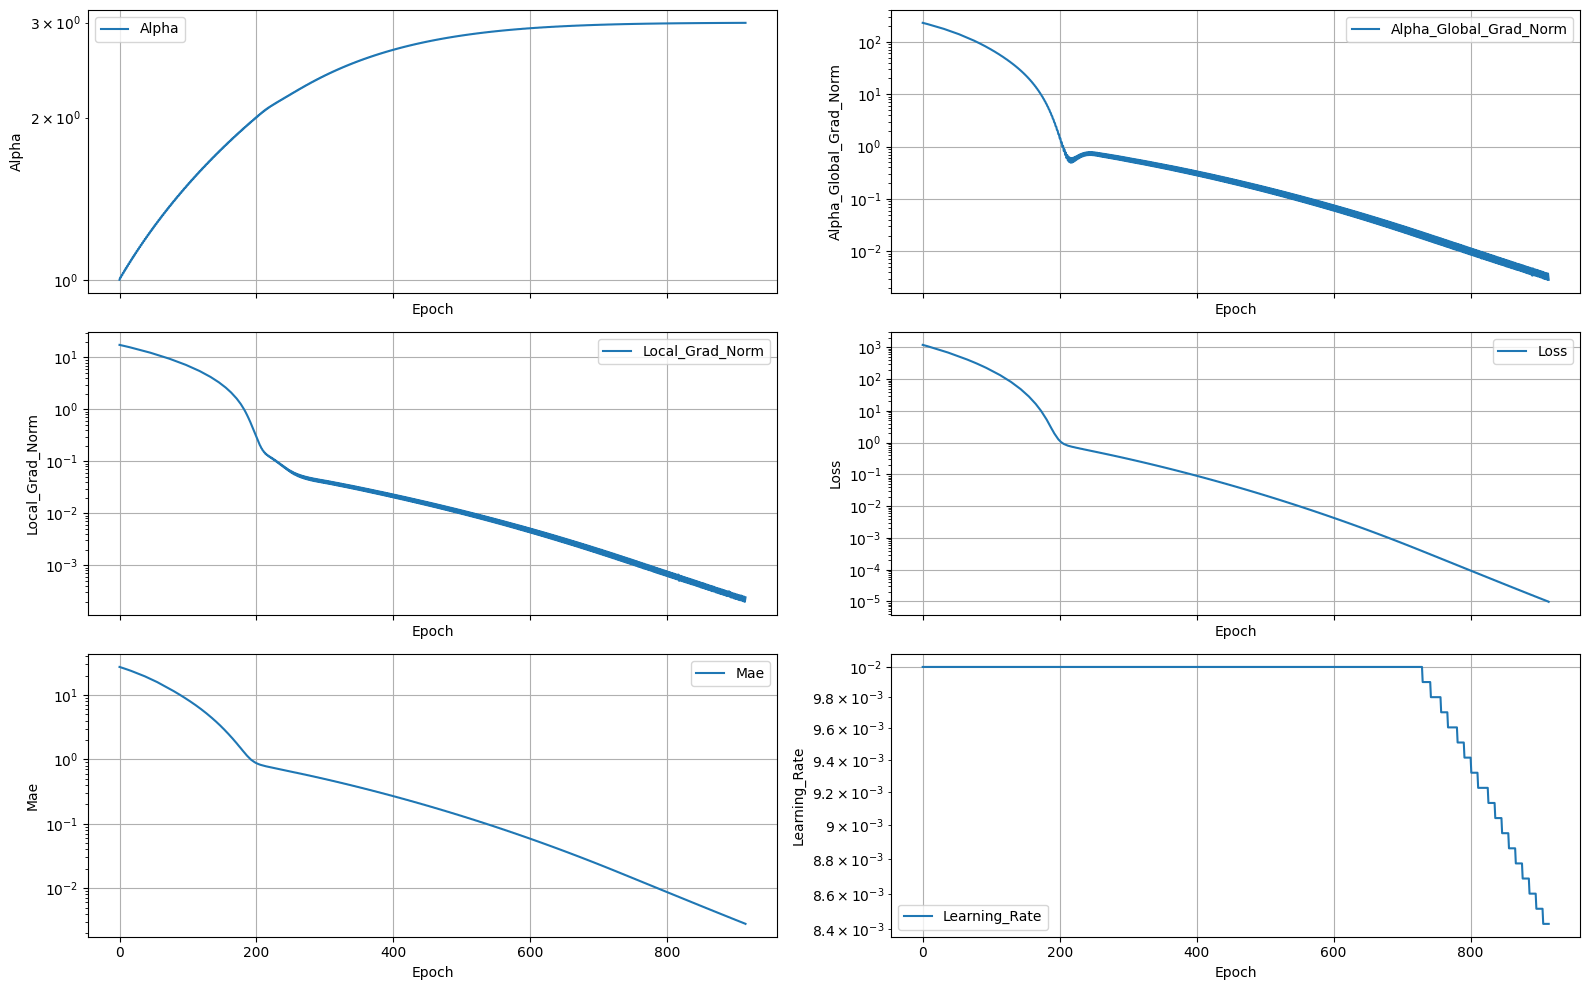

In [22]:
fig, _ = plot_history(history.history)
plt.savefig("convergance.png")
plt.show()

### Reload Trained Model and Inspect Global Parameters

- **Model loading:** restores a previously trained `ModelTrainer` instance from disk (`../examples/{model.name}.keras`) with `custom_objects` to resolve custom layers (`SigmoidModel1D`, `ModelTrainer`).  
  This ensures compatibility with TensorFlow’s serialization system.

- **Parameter inspection:** iterates over `model.global_trainable_weights` and prints each parameter name and its learned value.  
  Typical outputs include the global coefficient $\alpha$ and other shared parameters governing system-wide dynamics.

- **Purpose:** confirms that the reloaded model preserves the optimized state, enabling reproducibility, continuation of training, or downstream analysis.

In [23]:
model: ModelTrainer = tf.keras.models.load_model(
    filepath=os.path.join(
        '../examples',
        f'{model_name}.keras'
    ),
    custom_objects={
        "Model1D": Model1D,
        "ModelTrainer": ModelTrainer,
    }
)
model.name = model_name
for x in model.global_trainable_weights:
    print(f"{x.name} -> {x.numpy()}")

alpha -> 2.996577262878418


### Extract Ground Truth and Run Model Prediction

- **Ground-truth labels (`y_true`):**  
  - The training dataset `train_ds` is unbatched.  
  - A mapping function extracts only the target `y` values.  
  - These values are converted to NumPy arrays and stacked into `y_true`.  

- **Ground-truth velocities (`u_true`):**  
  - The velocity tensor is converted to a NumPy array and squeezed to remove singleton dimensions.  

- **Model predictions:**  
  - The model is run on `train_ds` with `steps=1`.  
  - Predictions return a tuple `(y_pred, u_pred)`.  
  - Both outputs are squeezed to simplify their shapes.  

- **Result:**  
  - `y_true` vs. `y_pred`: compare distance/trajectory predictions.  
  - `u_true` vs. `u_pred`: compare velocity predictions.  

In [24]:
y_true = np.array([y.numpy() for y in train_ds.unbatch().map(lambda x, y: y)])
u_true = np.squeeze(velocity)

y_pred, u_pred = model.predict(train_ds, steps=1)
y_pred = np.squeeze(y_pred)
u_pred = np.squeeze(u_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2025-09-25 06:50:32.769997: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Select Random Sample Trajectories for Visualization

- **Number of samples:**  
  `n_samples` specifies how many sequences will be plotted for inspection.

- **Random selection:**  
  Chooses `n_samples` unique indices from the full dataset of size $n_{\text{seq}}$:  
  $$
  \text{indices} \sim \text{Uniform}\big(\{0, 1, \dots, n_{\text{seq}}-1\}\big), \quad |\text{indices}| = n_{\text{samples}}
  $$

- **Purpose:**  
  Provides a representative subset of growth trajectories $(y_{\text{true}}, y_{\text{pred}}, u_{\text{true}}, u_{\text{pred}})$ for qualitative comparison and plotting, without needing to visualize all sequences at once.

In [29]:
n_samples = 12
seed = None # 123
rng = np.random.default_rng(seed=seed)
indices = rng.choice(y_true.shape[0], size=n_samples, replace=False)

### Visualize Sample Predictions for Length and Velocity

This section plots model predictions against ground-truth values for selected samples.

- **Length trajectories:**  
  - A first call to `plot_sequence_predictions` compares predicted vs. true length sequences `L(t)`.  
  - A suptitle is added showing  
    - The label: $L_{\text{true}}(t)$ vs. $L_{\text{pred}}(t)$  
    - Current values of global trainable weights (e.g., $\alpha_{\text{pred}}$).  
  - Layout is adjusted with `tight_layout` to leave space for the title.  
  - The figure is saved as **`length_samples.png`** and displayed.

- **Velocity trajectories:**  
  - A second call to `plot_sequence_predictions` compares velocity sequences $V(t)$.  
  - For each subplot, a horizontal dashed line (`axhline`) marks the reference value $X$ from `model.pde.X(i)`.  
  - A global legend is added in the top-right corner.  
  - The suptitle shows  
    - The label: $V_{\text{true}}(t)$ vs. $V_{\text{pred}}(t)$  
    - Current values of global trainable weights.  
  - The figure is saved as **`velocity_samples.png`** and displayed.

- **Result:**  
  Provides side-by-side comparisons of true vs. predicted trajectories, annotated with global parameters, giving insight into how well the model fits both length and velocity dynamics.

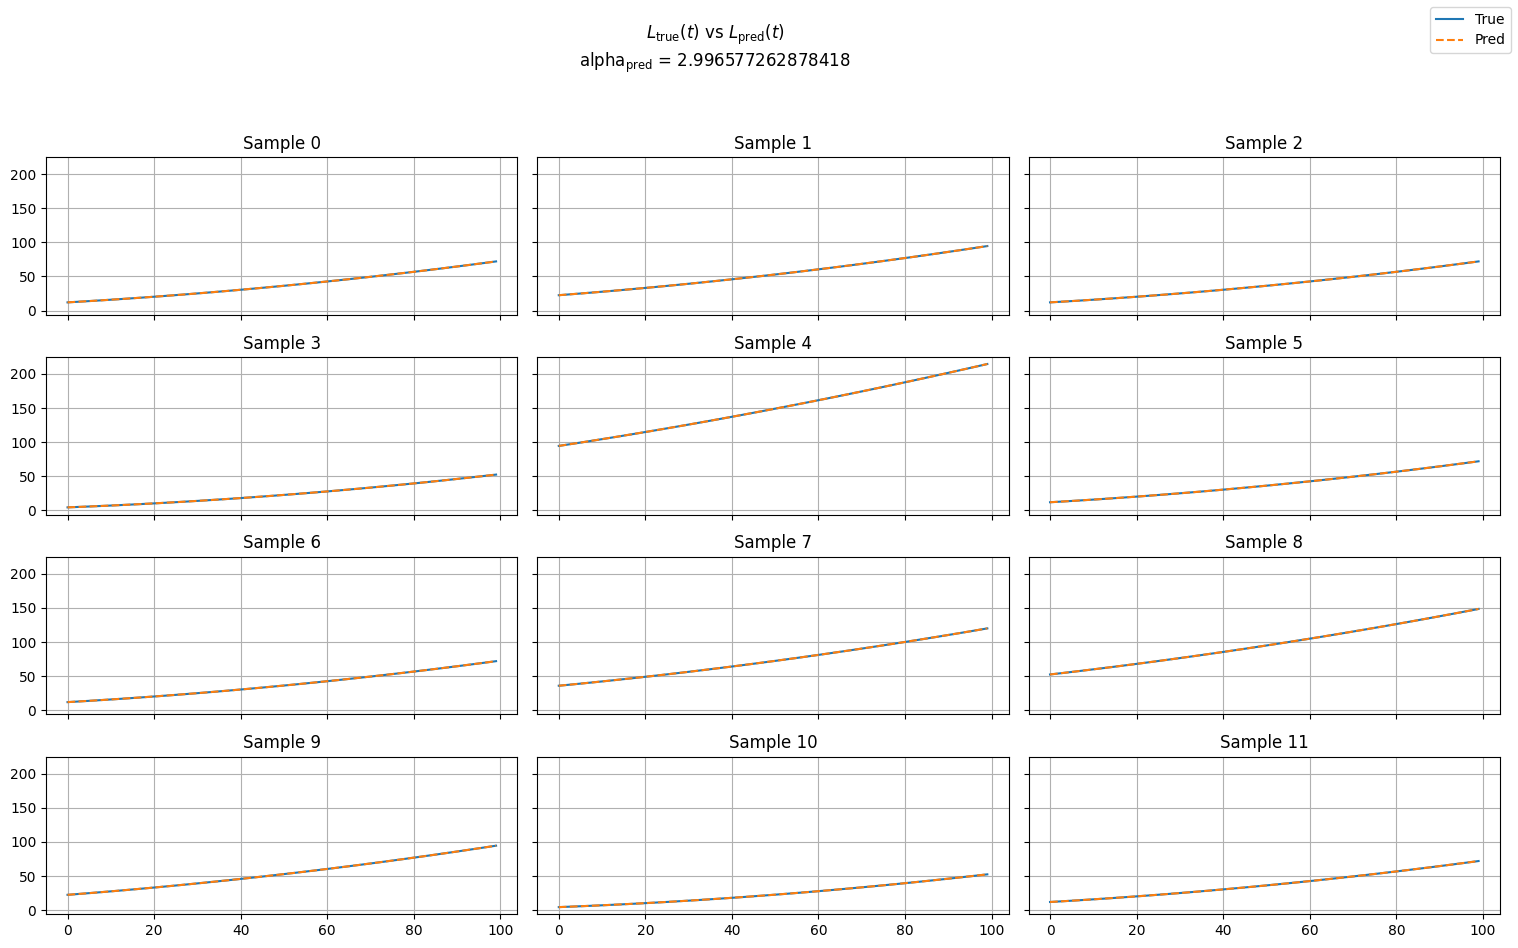

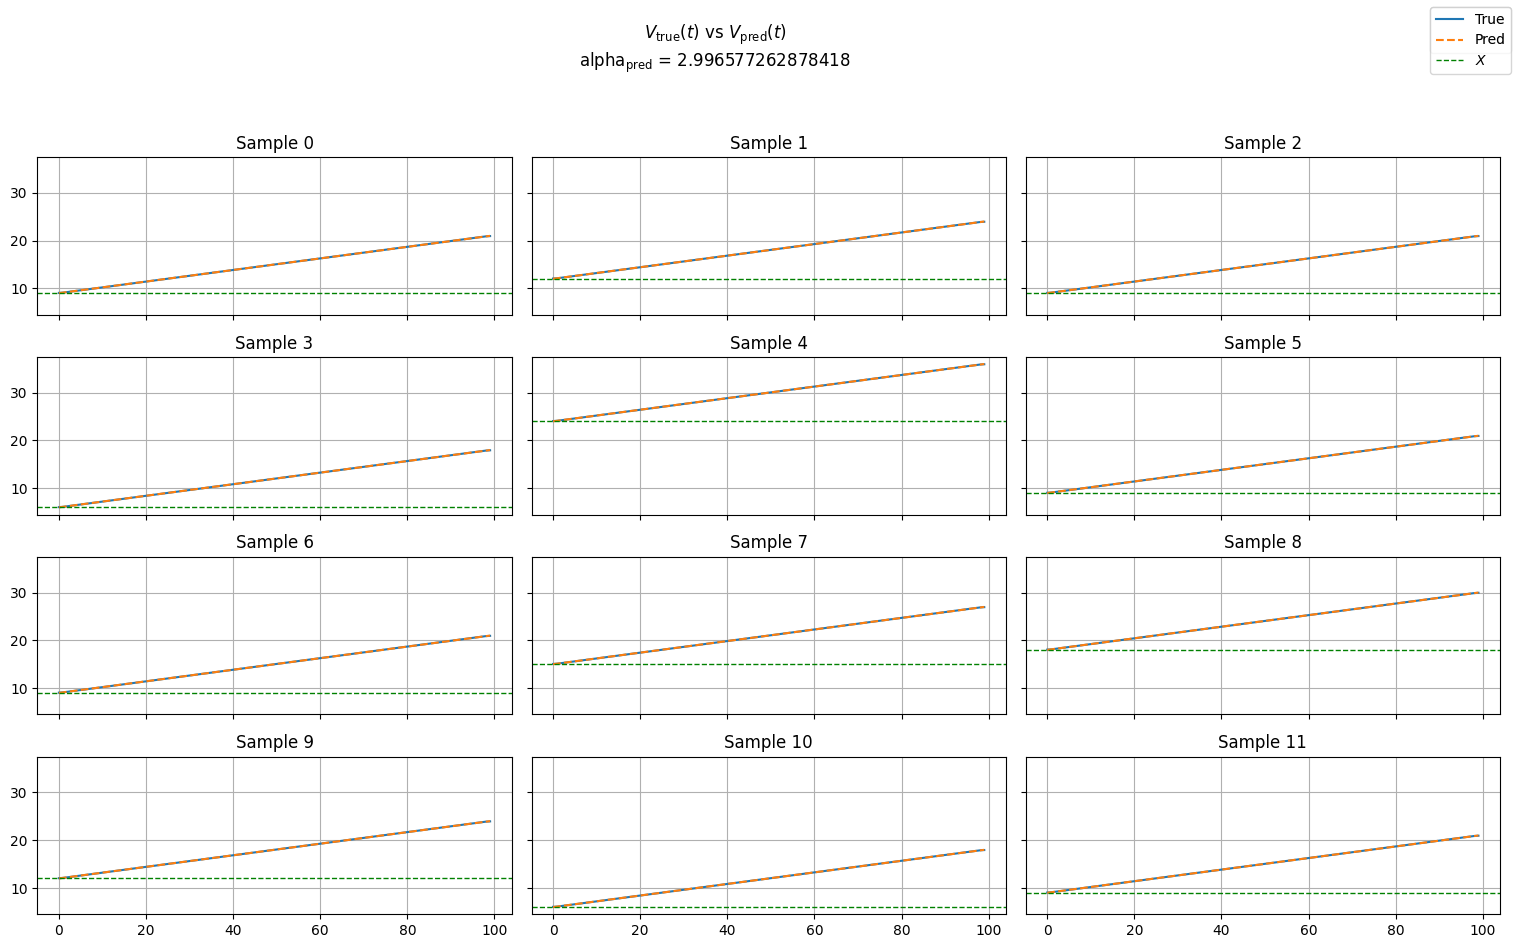

In [30]:
fig, _ = plot_sequence_predictions(
    y_true[indices], 
    y_pred[indices]
)
title = '\n'.join([
    r"$L_{\text{true}}(t)$ vs $L_{\text{pred}}(t)$",
    '\n'.join([
        f"{v.name}"+r'$_{\text{pred}}$'+f" = {v.numpy()}" for v in model.global_trainable_weights
    ])
])
fig.suptitle(title)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("length_samples.png")
plt.show()

fig, axes = plot_sequence_predictions(
    u_true[indices], 
    u_pred[indices]
)
for i, ax in zip(indices, axes):
    ax.axhline(y=model.pde.X(i), color='g', linestyle='--', linewidth=1, label=r"$X$")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
title = '\n'.join([
    r"$V_{\text{true}}(t)$ vs $V_{\text{pred}}(t)$",
    '\n'.join([
        f"{v.name}"+r'$_{\text{pred}}$'+f" = {v.numpy()}" for v in model.global_trainable_weights
    ])
])
fig.suptitle(title)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("velocity_samples.png")
plt.show()